In [19]:
with open('env.txt') as f:
    ENVIRONMENT = f.readlines()[0][:-1]
print(f'running on environment: "{ENVIRONMENT}"')
assert ENVIRONMENT in ['blaze',
                       'colab',
                       'local',
                       'cpom']


running on environment: "cpom"


In [20]:
if ENVIRONMENT == 'blaze':

    import subprocess
    import os

    command = 'source /usr/local/cuda/CUDA_VISIBILITY.csh'
    process = subprocess.Popen(command, shell=True, executable="/bin/csh", stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

    os.environ['CUDA_VISIBLE_DEVICES'] = stdout.decode()[-2]
    # os.environ['CUDA_HOME'] = '/opt/cuda/cuda-10.0'

    print(stdout.decode())

    command = 'source /server/opt/cuda/enable_cuda_11.0'
    process = subprocess.Popen(command, shell=True, executable="/bin/csh", stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

    !echo $CUDA_VISIBLE_DEVICES



In [21]:
if ENVIRONMENT == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.append('/content/drive/MyDrive/sis2/')
    

In [22]:
import tensorflow as tf

import os
import glob
import time
import datetime
import random

from matplotlib import pyplot as plt
import numpy as np

import sis_helper as helper
from sis_helper import RGBProfile as rgb

from models import pix2pix, psgan
from dataset.reader import Reader



In [23]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if True]

get_available_gpus()

['/device:CPU:0']

In [24]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [25]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [26]:
with tf.compat.v1.Session() as sess:
    device_name = tf.test.gpu_device_name()
    if device_name != '':
        print('TensorFlow is using GPU:', device_name)
    else:
        print('TensorFlow is not using GPU')

TensorFlow is not using GPU


In [27]:
TILESIZE = 256
IMG_WIDTH = 256
IMG_HEIGHT = 256

# TILESIZE = 960
# IMG_WIDTH = 1024
# IMG_HEIGHT = 1024

INPUT_CHANNELS = 21
OUTPUT_CHANNELS = 3

if ENVIRONMENT == 'blaze':
    PATH_PREFIX = '/cs/student/msc/aisd/2022/cboehm/projects/li1_data/'
elif ENVIRONMENT == 'colab':
    PATH_PREFIX = f'/content/drive/MyDrive/sis2/data/'
elif ENVIRONMENT == 'local':
    PATH_PREFIX = f'/Users/christianboehm/projects/sis2/data/'
elif ENVIRONMENT == 'cpom':
    PATH_PREFIX = f'/home/cb/sis2/data/'
else:
    PATH_PREFIX = f'~/projects/sis2/data'

PATH_TRAIN = os.path.join(PATH_PREFIX, f'tfrecords{TILESIZE}/')
PATH_VAL = os.path.join(PATH_PREFIX, f'tfrecords{TILESIZE}/')
PATH_LOGS = os.path.join(PATH_PREFIX, 'logs/')
PATH_CKPT = os.path.join(PATH_PREFIX, 'checkpoints/')
PATH_IMGS = os.path.join(PATH_PREFIX, 'images/')

# The training set consist of n images
BUFFER_SIZE = number_of_files = len(glob.glob(os.path.join(PATH_TRAIN, '*')))
# BUFFER_SIZE = 1077
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
LAMBDA = 100


In [28]:
# model = pix2pix.Model(IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS, OUTPUT_CHANNELS, LAMBDA, PATH_LOGS, PATH_CKPT)
model = psgan.Model(IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS, OUTPUT_CHANNELS, LAMBDA, PATH_LOGS, PATH_CKPT)

dataset_reader = Reader(TILESIZE, IMG_HEIGHT, IMG_WIDTH, PATH_TRAIN, PATH_VAL, BUFFER_SIZE, BATCH_SIZE)
train_dataset = dataset_reader.train_dataset
test_dataset = dataset_reader.test_dataset


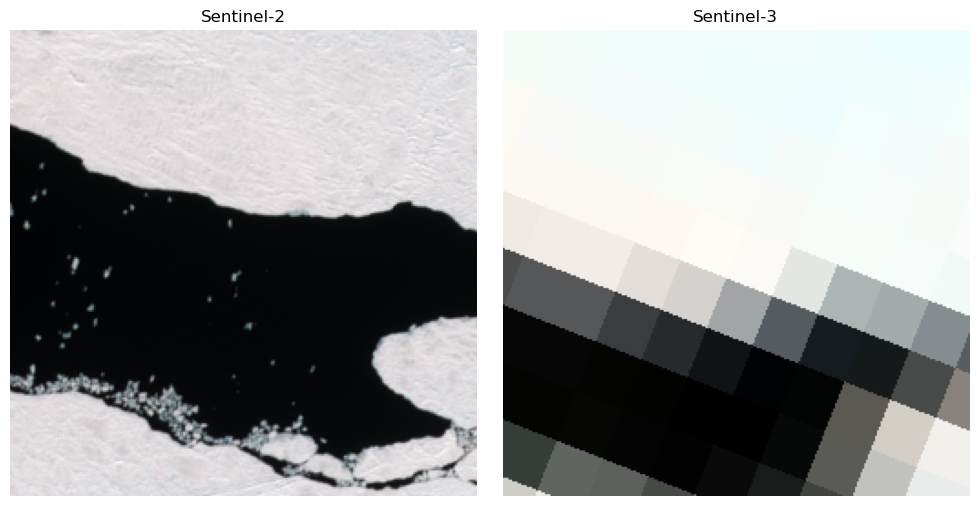

In [29]:
sample_dataset = tf.data.TFRecordDataset(os.path.join(PATH_VAL, random.choice(os.listdir(PATH_VAL))))
for element in sample_dataset:
    helper.plot_tensor_sbs(element, TILESIZE)
    s2_tensor, s3_tensor = helper.parse_tfrecord(element, TILESIZE)
    s2_tensor, s3_tensor = dataset_reader.resize(s2_tensor, s3_tensor, IMG_HEIGHT, IMG_WIDTH)

    # helper.plot_tensor(s2_tensor, rgb.S2)
    # helper.plot_tensor(s3_tensor, rgb.S3)


In [30]:
# # down_model = downsample(64, 4)
# down_result = downsample(64, 4)(tf.expand_dims(s3_tensor, 0))
# down_result = downsample(128, 4)(down_result)
# print (down_result.shape)

In [31]:
# up_model = upsample(21, 4)
# up_result = up_model(down_result)
# print (up_result.shape)

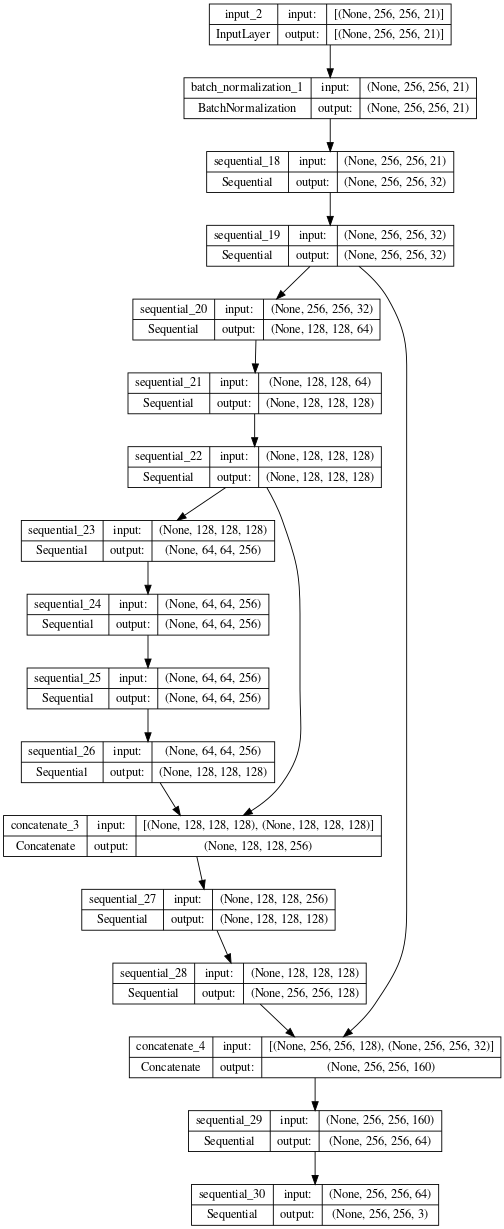

In [32]:
generator = model.generator
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)


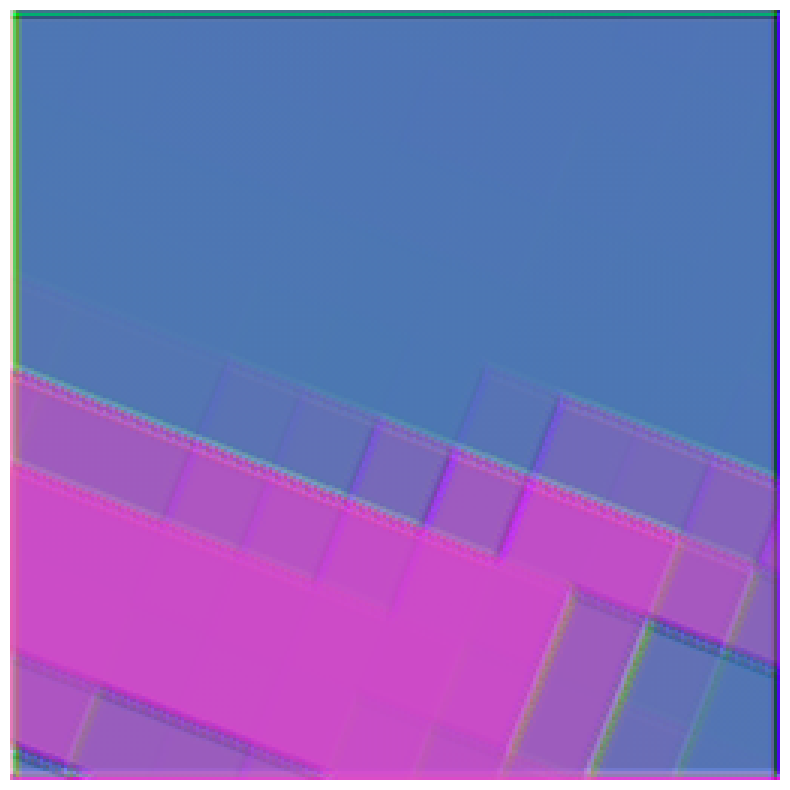

In [33]:
gen_output = generator(s3_tensor[tf.newaxis, ...], training=False)
helper.plot_tensor(gen_output[0], rgb.S2)


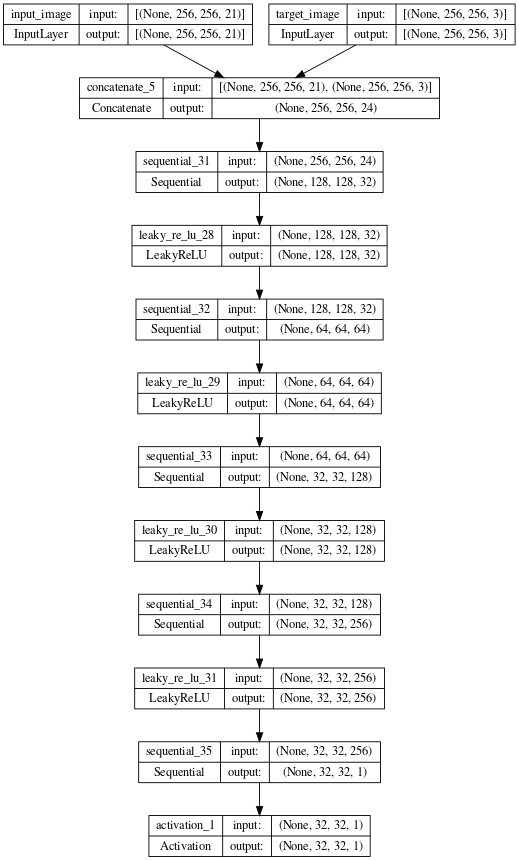

In [34]:
discriminator = model.discriminator
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)


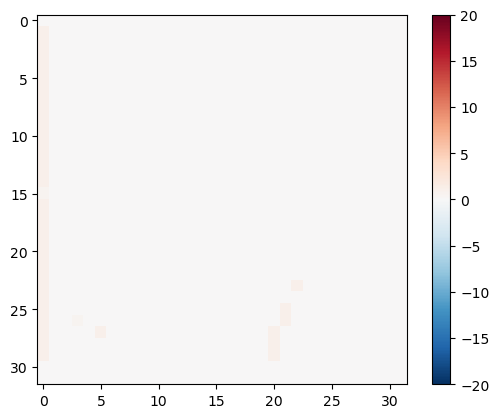

In [35]:
disc_out = discriminator([s3_tensor[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()


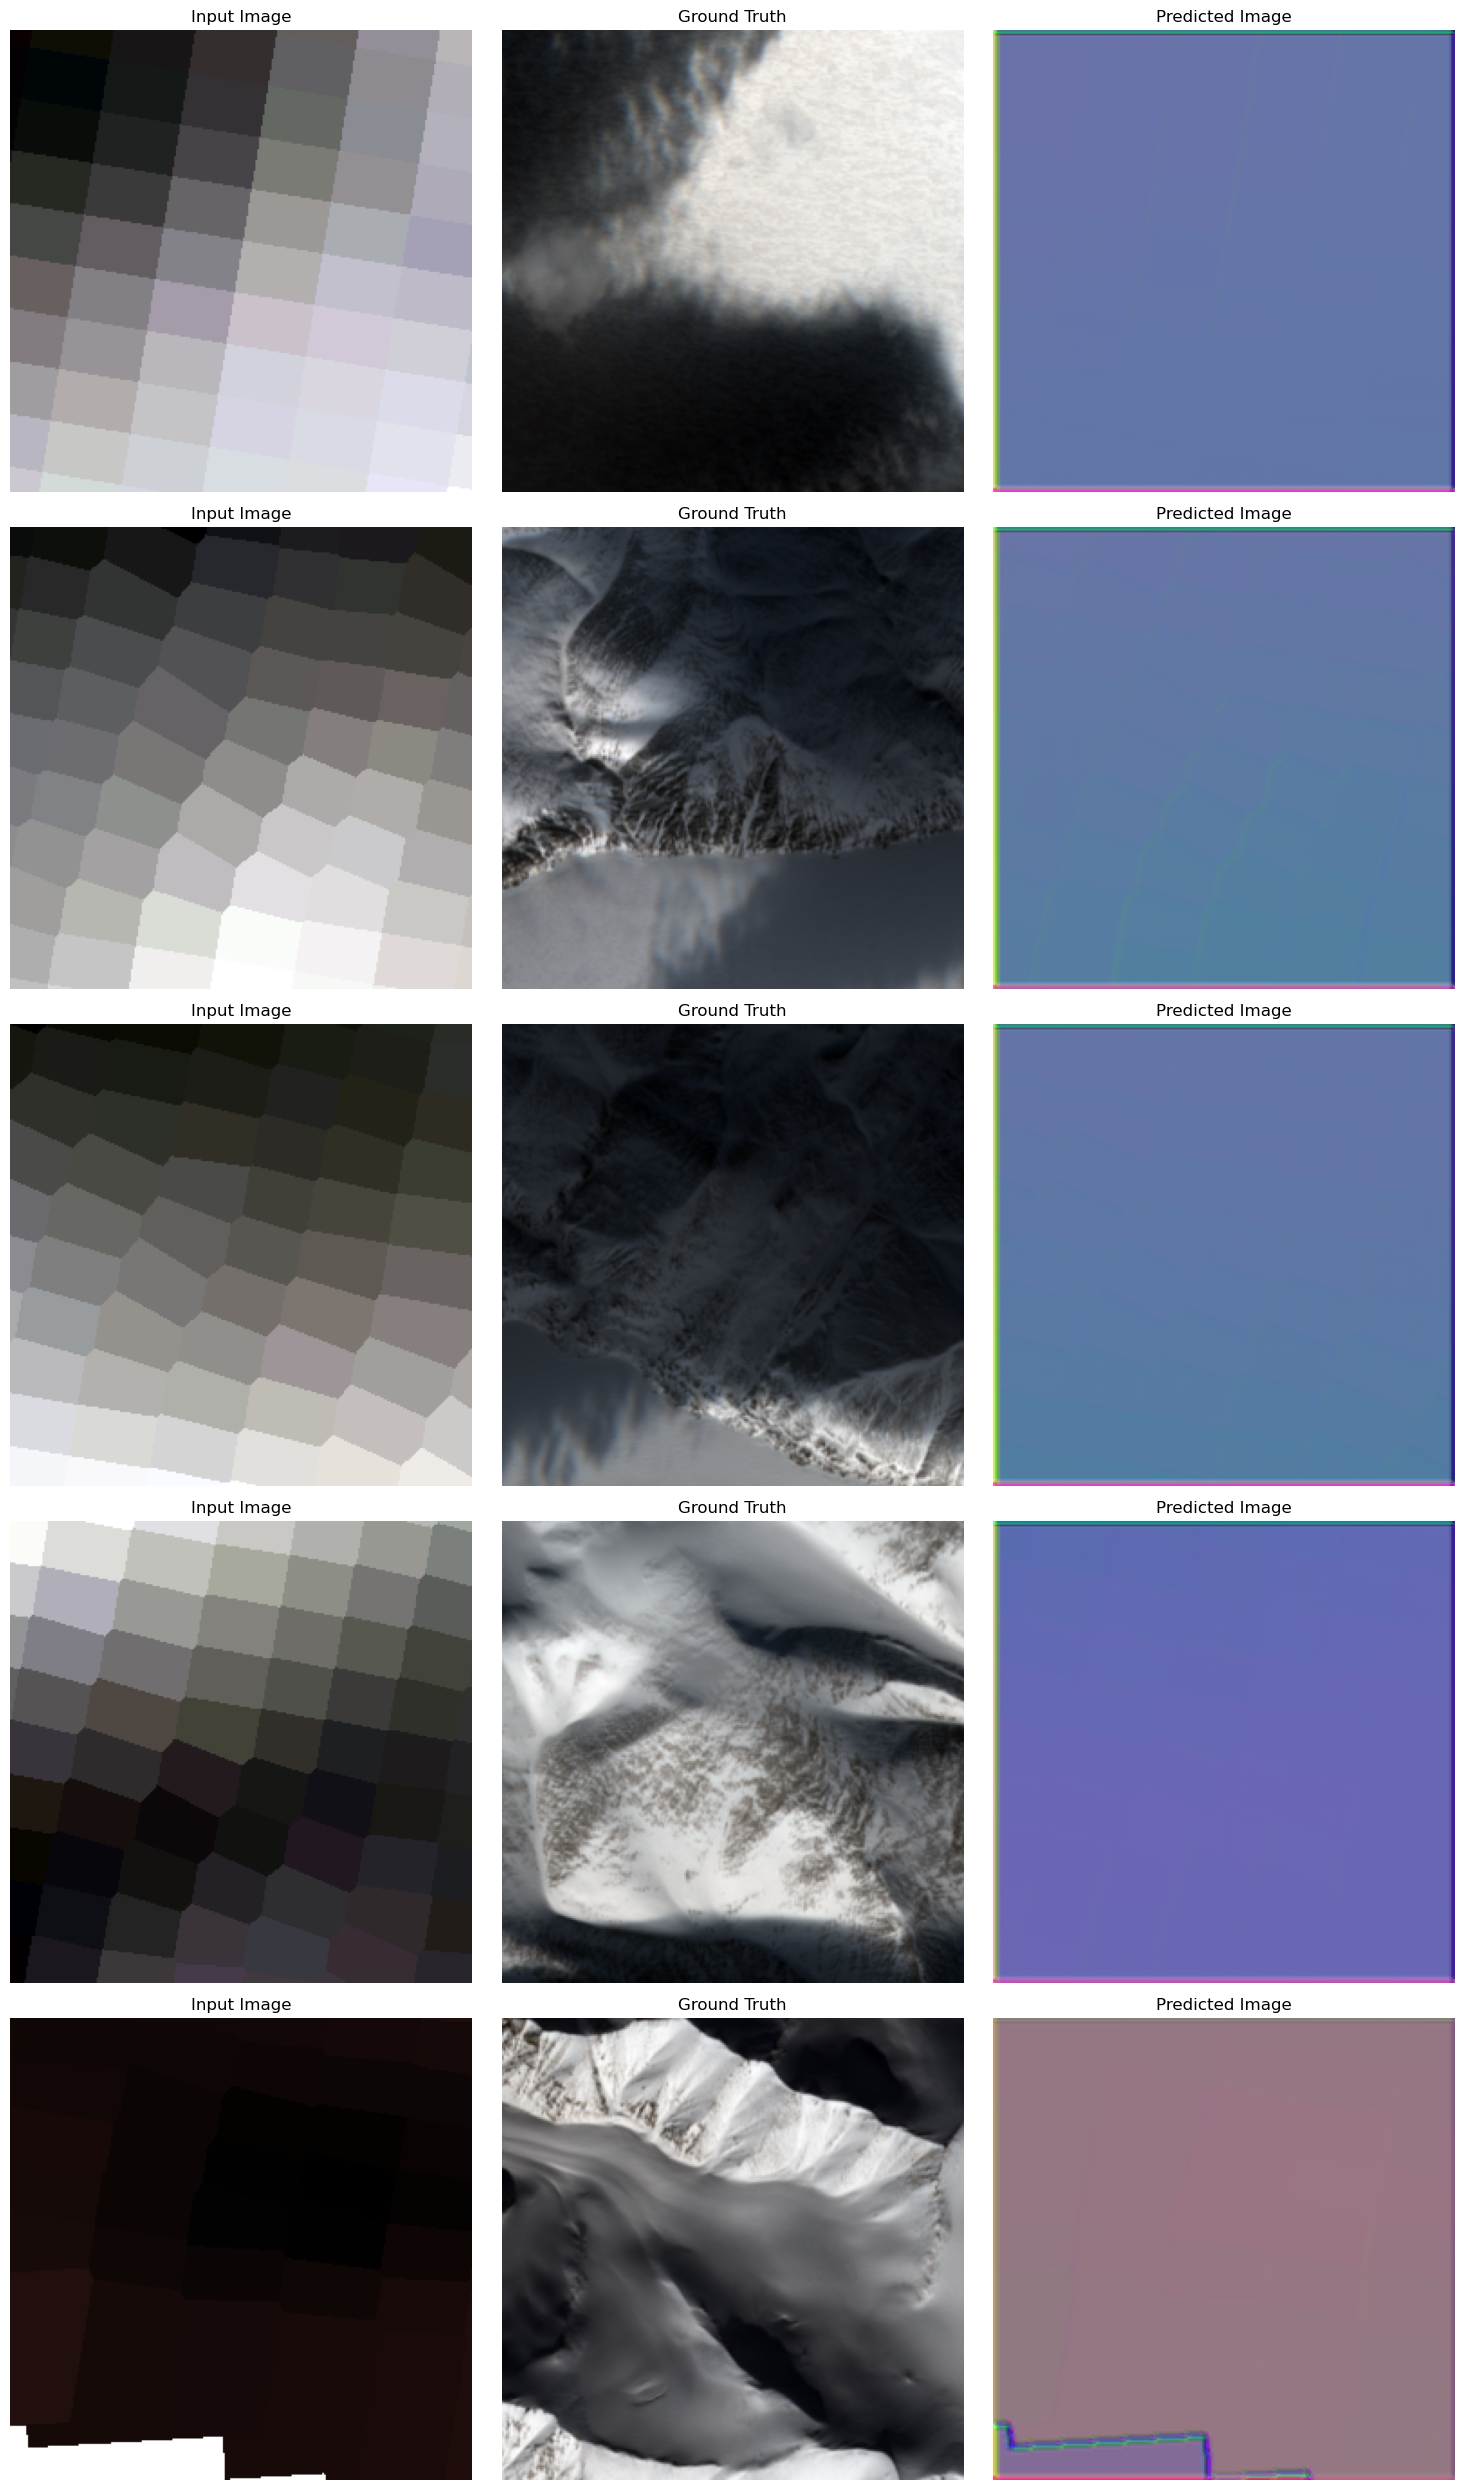

In [78]:
example_targets = []
example_inputs = []
for example_target, example_input in test_dataset.take(5):
    example_targets.append(example_target[0])
    example_inputs.append(example_input[0])

helper.generate_images(generator, tf.stack(example_inputs, axis=0), tf.stack(example_targets, axis=0))


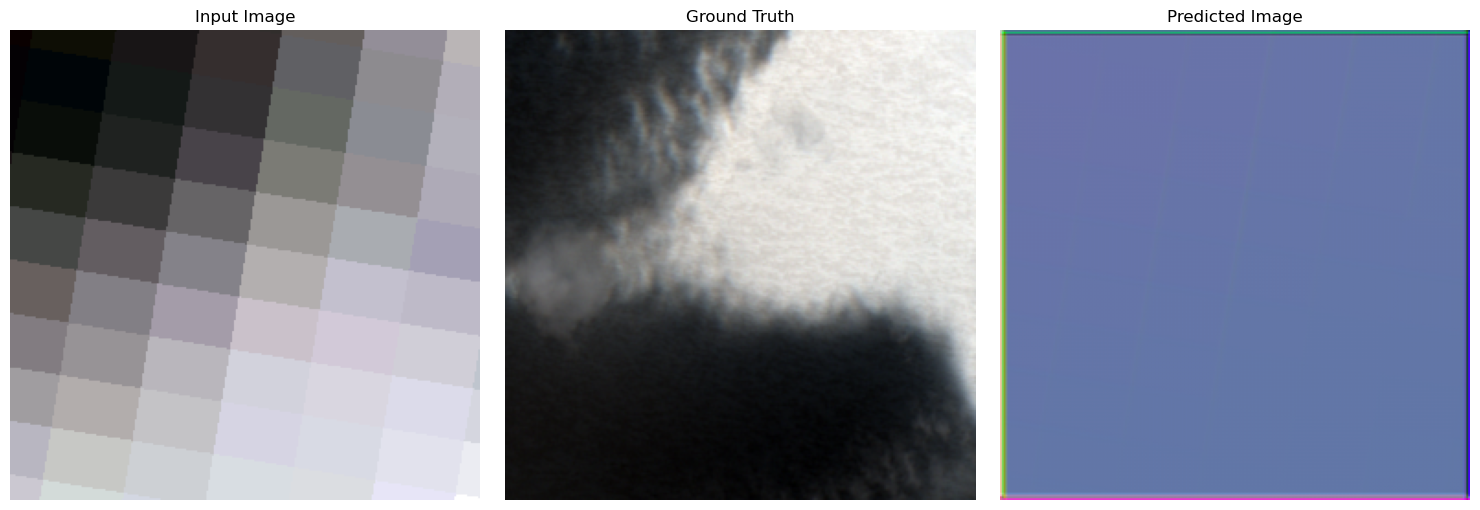

In [36]:
for example_target, example_input in test_dataset.take(1):
    helper.generate_images(generator, example_input, example_target)
    

In [ ]:
def fit(train_ds, test_ds, steps):
    # example_target, example_input = next(iter(test_ds.take(1)))
    starttimestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    start = time.time()
    
    for step, (target, input_image) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            # display.clear_output(wait=True)
            
            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
                start = time.time()

            for example_target, example_input in test_dataset.take(1):
                helper.generate_images(generator, example_input, example_target, showimg=True)

            print(f"Step: {step // 1000}k")

        model.train_step(input_image, target, step)

        # Training step
        if (step + 1) % 10 == 0:
            print('.', end='', flush=True)

        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            model.save()

In [ ]:
fit(train_dataset, test_dataset, steps=5000)

In [ ]:
# !tensorboard dev upload --logdir {PATH_LOGS}
